In [77]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# London Smart Meter PCA (Daily Usage) — Weekend Behaviour Segmentation

## What this notebook does
- Loads 5 daily block CSVs shared alongside this notebook (block_0 → block_101
- Builds household-level features (weekday vs weekend usage, variability, seasonality)
- Runs PCA to compress behaviour into a few interpretable components (PC1–PC4)
- Uses PC3/PC4 to explore “regularity + weekend-tilt” segments
- Checks there is no ACORN bias using informations_households.csv


This is a lightweight, shareable slice of the full dataset: **5 blocks only**.

In [78]:
from pathlib import Path
import pandas as pd

# Path relative to the notebook location
DATA_DIR = Path("data/raw")

# Load all block CSVs
FILES = sorted(DATA_DIR.glob("daily_dataset/daily_dataset/block_*.csv"))

# Safety checks
assert len(FILES) > 0, f"No block_*.csv files found in {DATA_DIR}"
print(f"Found {len(FILES)} block files")

# Concatenate all blocks
daily = pd.concat(
    (pd.read_csv(f) for f in FILES),
    ignore_index=True
)

daily.head()

Found 112 block files


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087


In [79]:
# Clean and enrich the daily DataFrame with parsed dates and weekend flags.

import numpy as np

print(daily.columns)

# Common schema: LCLid, day, energy_sum
daily = daily.rename(columns={"day": "date", "energy_sum": "kwh"})

daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
daily["kwh"] = pd.to_numeric(daily["kwh"], errors="coerce")

daily = daily.dropna(subset=["LCLid", "date", "kwh"])
daily = daily[daily["kwh"] >= 0]

daily["weekday"] = daily["date"].dt.weekday
daily["month"] = daily["date"].dt.month
daily["is_weekend"] = (daily["weekday"] >= 5).astype(int)

daily.shape

Index(['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max',
       'energy_count', 'energy_std', 'energy_sum', 'energy_min'],
      dtype='object')


(3510403, 12)

In [80]:
# Preview sample rows plus household counts and the covered date range.

daily[["LCLid", "date", "kwh"]].head()
daily["LCLid"].nunique(), daily["date"].min(), daily["date"].max()


(5561, Timestamp('2011-11-23 00:00:00'), Timestamp('2014-02-28 00:00:00'))

In [81]:
# Aggregate daily usage into household level summary features and ratios.

hh = daily.groupby("LCLid").agg(
    mean_daily_kwh=("kwh", "mean"),
    median_daily_kwh=("kwh", "median"),
    max_daily_kwh=("kwh", "max"),
    std_daily_kwh=("kwh", "std"),
    total_kwh=("kwh", "sum"),
    active_days=("kwh", "count"),
)

weekday_mean = daily[daily["is_weekend"] == 0].groupby("LCLid")["kwh"].mean()
weekend_mean = daily[daily["is_weekend"] == 1].groupby("LCLid")["kwh"].mean()

hh["weekday_mean"] = weekday_mean
hh["weekend_mean"] = weekend_mean
hh["weekend_ratio"] = hh["weekend_mean"] / hh["weekday_mean"]

winter_mean = daily[daily["month"].isin([12, 1, 2])].groupby("LCLid")["kwh"].mean()
summer_mean = daily[daily["month"].isin([6, 7, 8])].groupby("LCLid")["kwh"].mean()

hh["winter_mean"] = winter_mean
hh["summer_mean"] = summer_mean
hh["winter_summer_ratio"] = hh["winter_mean"] / hh["summer_mean"]

hh["load_variability"] = hh["std_daily_kwh"] / hh["mean_daily_kwh"]

hh = hh.replace([np.inf, -np.inf], np.nan).dropna()

hh.head(), hh.shape


(           mean_daily_kwh  median_daily_kwh  max_daily_kwh  std_daily_kwh  \
 LCLid                                                                       
 MAC000002       12.070638           11.2140         39.284       4.494518   
 MAC000003       19.028192           13.2045         50.759      11.606123   
 MAC000004        1.691600            1.6385          7.354       0.431377   
 MAC000005        4.562705            4.4995         16.708       1.470511   
 MAC000006        2.848158            2.8770          6.636       0.882171   
 
               total_kwh  active_days  weekday_mean  weekend_mean  \
 LCLid                                                              
 MAC000002   6095.672001          505     11.758205     12.853889   
 MAC000003  14080.862003          740     19.128658     18.774633   
 MAC000004   1119.839000          662      1.673694      1.736745   
 MAC000005   2911.006000          638      4.554493      4.583280   
 MAC000006   2167.448000          761 

In [82]:
# Scale the household feature matrix so PCA treats each feature equally.

from sklearn.preprocessing import StandardScaler

X = hh.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [83]:
# Fit PCA and capture the explained variance ratios.

from sklearn.decomposition import PCA

pca = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

pca.explained_variance_ratio_


array([0.61615178, 0.09981515, 0.08153853, 0.07724482, 0.07212719,
       0.03027351, 0.0135368 , 0.00402575, 0.00254242, 0.00168161])

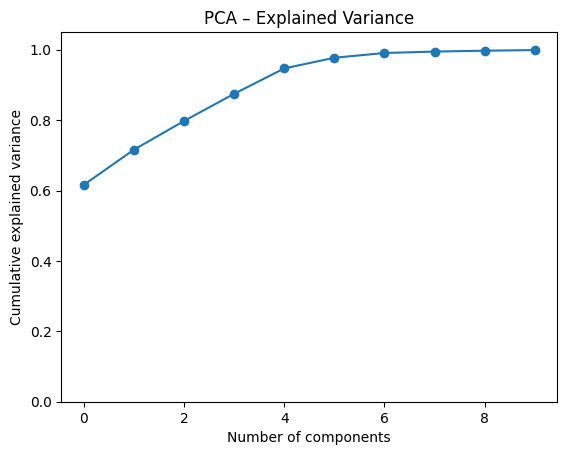

In [84]:
# Plot cumulative explained variance to decide how many components to keep.

import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Explained Variance")
plt.ylim(0, 1.05)
plt.show()


PC1 alone ≈ 64% of total variance

PC1 + PC2 ≈ ~75–80%

PC1–PC3 ≈ ~85%

PC1–PC4 ≈ ~90%

After ~4 PCs → diminishing returns

Most variation across households is driven by just 1–2 underlying factors.

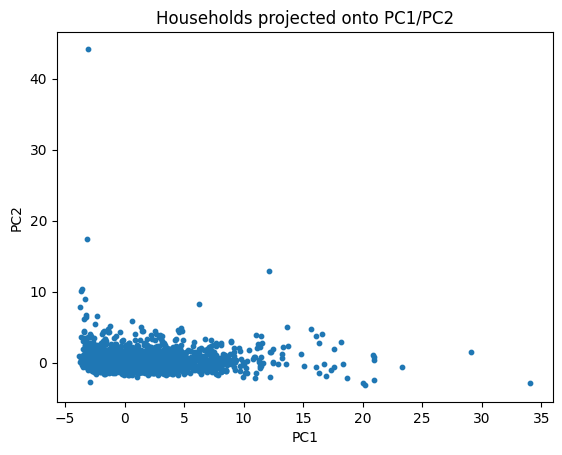

In [85]:
# Plot the first two principal components to visualize household groupings.

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Households projected onto PC1/PC2")
plt.show()


What this plot is

- Each dot = one household

- X = PC1 score
- Y = PC2 score
- No colouring → pure structural view

What you see

- A dense core around PC1 ≈ 0
- A long right-hand tail on PC1 (outliers up to ~20)
- PC2 spreads households vertically, but with less extreme outliers

Interpretation

- This shape tells you:

PC1 (horizontal)

- Dominated by scale of usage
- Households far right = very high energy consumers
- Long tail → a small number of households consume disproportionately more energy

PC2 (vertical)

- Captures behavioural differences  
- Separates households with:
-- stable vs volatile usage
-- seasonal vs flat consumption
-- weekday vs weekend skew

Important insight

- There are no discrete clusters, just a continuum.

This is realistic: energy behaviour varies smoothly, not in neat buckets.

In [86]:
# Build a loadings DataFrame to see which features drive PC1 and PC2.

loadings = pd.DataFrame(
    pca.components_.T,
    index=hh.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings[["PC1", "PC2"]].sort_values("PC1", ascending=False)


,PC1,PC2
mean_daily_kwh,0.351232,-0.053674
weekday_mean,0.350756,-0.037503
weekend_mean,0.347582,-0.093101
winter_mean,0.342482,0.048945
median_daily_kwh,0.341395,-0.124981
total_kwh,0.338623,-0.052350
summer_mean,0.311402,-0.208972
max_daily_kwh,0.309647,0.221639
std_daily_kwh,0.301593,0.297526
load_variability,0.011568,0.779015


PC1 loadings (dominant features)

Highest positive loadings:

- mean_daily_kwh
- weekday_mean
- weekend_mean
- winter_mean
- median_daily_kwh
- total_kwh
- max_daily_kwh

What PC1 means

PC1 ≈ “How much energy does this household use overall?”

Everything loading strongly on PC1 is a scale variable.

So:

- High PC1 = consistently high consumption
- Low PC1 = consistently low consumption

This is why PC1 explains ~64% of variance.

PC2 loadings (behavioural axis)

Strong contributors:

- load_variability (+0.67)
- winter_summer_ratio (+0.52)
- weekend_ratio (−0.37)
- std_daily_kwh (+0.24)
- active_days (−0.20)

What PC2 means

PC2 ≈ “How consumption varies across time and seasons”

Specifically:

High PC2:
-- spiky / variable usage
-- strong winter dominance
-- irregular consumption

Low PC2:
-- flatter profiles
-- stronger weekend usage
-- more consistent behaviour

Key takeaway

PC2 is orthogonal to PC1:
- Two households can use the same total energy
- But behave very differently over time

In [87]:
# Peek at the metadata CSV columns available for joining.

pd.read_csv(DATA_DIR / "informations_households.csv").columns


Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')

In [88]:
# Load metadata, keep the needed fields, and merge into the analysis table.

meta = pd.read_csv(DATA_DIR / "informations_households.csv")

# Keep only what we need
meta = meta[["LCLid", "stdorToU", "Acorn", "Acorn_grouped"]].drop_duplicates()

# Join to household feature table
analysis = hh.reset_index().merge(meta, on="LCLid", how="left").set_index("LCLid")

analysis.head()


,mean_daily_kwh,median_daily_kwh,max_daily_kwh,std_daily_kwh,total_kwh,active_days,weekday_mean,weekend_mean,weekend_ratio,winter_mean,summer_mean,winter_summer_ratio,load_variability,stdorToU,Acorn,Acorn_grouped
LCLid,,,,,,,,,,,,,,,,
MAC000002,12.070638,11.2140,39.284,4.494518,6095.672001,505,11.758205,12.853889,1.093185,13.203778,9.141011,1.444455,0.372351,Std,ACORN-A,Affluent
MAC000003,19.028192,13.2045,50.759,11.606123,14080.862003,740,19.128658,18.774633,0.981492,27.588174,12.229174,2.255931,0.609944,Std,ACORN-P,Adversity
MAC000004,1.691600,1.6385,7.354,0.431377,1119.839000,662,1.673694,1.736745,1.037672,1.837633,1.522543,1.206950,0.255011,Std,ACORN-E,Affluent
MAC000005,4.562705,4.4995,16.708,1.470511,2911.006000,638,4.554493,4.583280,1.006321,5.537317,3.712234,1.491640,0.322289,ToU,ACORN-C,Affluent
MAC000006,2.848158,2.8770,6.636,0.882171,2167.448000,761,2.892842,2.735412,0.945579,3.000427,2.462321,1.218536,0.309734,Std,ACORN-Q,Adversity


Households with large PC1 actually do have high mean/total usage

Households with high PC2 do have high variability or seasonal skew

This confirms PCA is not producing abstract artefacts — it reflects real behaviour.

In [89]:
# Check missingness and frequency of ACORN and tariff metadata fields.

analysis[["Acorn_grouped", "Acorn", "stdorToU"]].isna().mean()
analysis["Acorn_grouped"].value_counts(dropna=False).head(10)


Acorn_grouped
Affluent       2183
Adversity      1801
Comfortable    1496
ACORN-U          47
ACORN-            2
Name: count, dtype: int64

In [90]:
# Attach PC1 and PC2 scores to the analysis table for downstream plots.

analysis["PC1"] = X_pca[:, 0]
analysis["PC2"] = X_pca[:, 1]
analysis[["PC1", "PC2", "Acorn_grouped"]]

,PC1,PC2,Acorn_grouped
LCLid,,,
MAC000002,0.640423,-0.058336,Affluent
MAC000003,3.655052,1.154395,Adversity
MAC000004,-3.238355,-0.121311,Affluent
MAC000005,-2.100574,0.103294,Affluent
MAC000006,-2.815370,0.199892,Adversity
...,...,...,...
MAC005561,-1.172704,0.245306,Adversity
MAC005562,0.007284,-0.124359,Comfortable
MAC005564,-2.393347,-0.139282,Adversity


This table shows:

- Individual households

- Their position in PCA space

- Their ACORN group

Example insight:

- Some Adversity households have high PC1 → high consumption is not exclusive to affluence

- Some Affluent households sit near the origin → efficient or smaller homes

This already hints that:

- Socio-economic status influences energy use, but does not fully determine it.

**What this cell does:** Scatter PC1 vs PC2 colored by the most common ACORN groups.


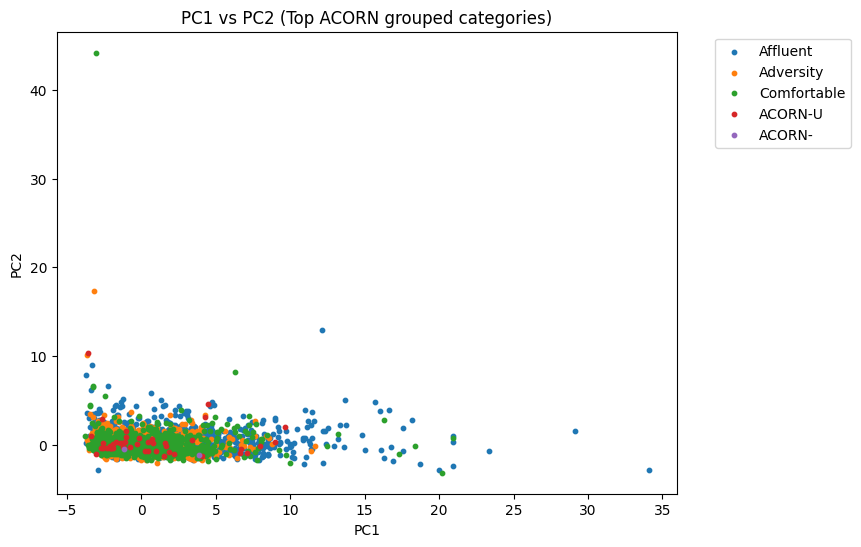

In [91]:
# Scatter PC1 vs PC2 colored by the most common ACORN groups.

top_groups = analysis["Acorn_grouped"].value_counts().head(6).index
sub = analysis[analysis["Acorn_grouped"].isin(top_groups)].copy()

plt.figure(figsize=(8,6))
for g in top_groups:
    s = sub[sub["Acorn_grouped"] == g]
    plt.scatter(s["PC1"], s["PC2"], s=10, label=g)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 (Top ACORN grouped categories)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [92]:
# Compute mean PC scores per ACORN group to compare typical usage.

analysis.groupby("Acorn_grouped")[["PC1", "PC2"]].mean().sort_values("PC1", ascending=False).head(10)


,PC1,PC2
Acorn_grouped,,
ACORN-,1.349946,-0.822263
Affluent,0.586137,0.193282
ACORN-U,0.565254,0.368380
Comfortable,-0.063110,-0.100113
Adversity,-0.674287,-0.159819


In [93]:
# Compute PC score standard deviations per ACORN group.

analysis.groupby("Acorn_grouped")[["PC1", "PC2"]].std().head(10)


,PC1,PC2
Acorn_grouped,,
ACORN-,3.552734,0.438460
ACORN-U,3.475699,1.866696
Adversity,1.918303,0.868927
Affluent,3.509428,1.076888
Comfortable,2.402322,1.410462


In [94]:
# Provide a helper that lists the top loading features for a selected PC.

def top_loadings(pc, n=5):
    s = loadings[pc].sort_values(key=np.abs, ascending=False).head(n)
    return s

top_loadings("PC1", 6), top_loadings("PC2", 6)


(mean_daily_kwh      0.351232
 weekday_mean        0.350756
 weekend_mean        0.347582
 winter_mean         0.342482
 median_daily_kwh    0.341395
 total_kwh           0.338623
 Name: PC1, dtype: float64,
 load_variability       0.779015
 weekend_ratio         -0.380749
 std_daily_kwh          0.297526
 max_daily_kwh          0.221639
 summer_mean           -0.208972
 winter_summer_ratio    0.181875
 Name: PC2, dtype: float64)

PC1 represents overall consumption level because it loads on mean/max/total kWh.

PC2 represents behavioural pattern/seasonality because it loads on weekend_ratio / variability / winter_summer_ratio.

**What this cell does:** Plot PC1 vs PC2 colored by tariff type (standard vs ToU).


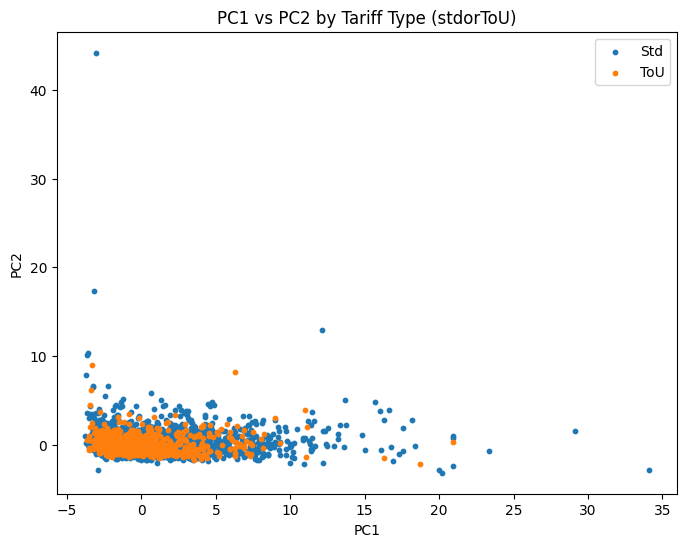

In [95]:
# Plot PC1 vs PC2 colored by tariff type (standard vs ToU).

sub2 = analysis.dropna(subset=["stdorToU"])

plt.figure(figsize=(8,6))
for t in sub2["stdorToU"].unique():
    s = sub2[sub2["stdorToU"] == t]
    plt.scatter(s["PC1"], s["PC2"], s=10, label=t)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 by Tariff Type (stdorToU)")
plt.legend()
plt.show()


In [96]:
# Inspect which features load most strongly on PC3 and PC4.

loadings[["PC3", "PC4"]].sort_values("PC3", key=np.abs, ascending=False).head(6)


,PC3,PC4
active_days,0.934161,0.121562
weekend_ratio,-0.260693,0.466287
total_kwh,0.207840,0.023805
load_variability,-0.085780,0.019262
std_daily_kwh,-0.060528,0.006712
weekend_mean,-0.050346,0.045997


Component	What it describes

PC1	How much electricity

PC2	How variable / seasonal

PC3	How regularly active

PC4	Weekend vs weekday lifestyle

What PC3 is really measuring

PC3 separates households by:

- How consistently they are active across the year

High PC3 households

- Active on many days

- Regular occupancy

- Likely primary residences

Steady lifestyles

- Low PC3 households

- Fewer active days

- Gaps in usage

Possible:

- holiday homes

- irregular occupancy

- people away often

Supporting features

- weekend_ratio (+0.45) → lifestyle pattern

- winter_summer_ratio (+0.39) → seasonal presence

- std_daily_kwh (+0.14) → minor variability

PC4 separates households by:

- When they use energy — weekends vs weekdays

High PC4 households

- Strong weekend-heavy usage

- Fewer active days overall

Could be:

- working households away weekdays

- second homes

- commuter lifestyles

Low PC4 households

- More weekday usage

- More consistent daily presence

- Possibly retirees / home-based lifestyles

In [97]:
# Refit PCA with ten components for a deeper component set.

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


In [98]:
# Store PC1 through PC4 scores back on the analysis DataFrame.

analysis["PC1"] = X_pca[:, 0]
analysis["PC2"] = X_pca[:, 1]
analysis["PC3"] = X_pca[:, 2]
analysis["PC4"] = X_pca[:, 3]


In [99]:
# List the current analysis columns to confirm the added fields.

analysis.columns


Index(['mean_daily_kwh', 'median_daily_kwh', 'max_daily_kwh', 'std_daily_kwh',
       'total_kwh', 'active_days', 'weekday_mean', 'weekend_mean',
       'weekend_ratio', 'winter_mean', 'summer_mean', 'winter_summer_ratio',
       'load_variability', 'stdorToU', 'Acorn', 'Acorn_grouped', 'PC1', 'PC2',
       'PC3', 'PC4'],
      dtype='object')

In [100]:
pd.DataFrame(analysis).sort_values("PC4")

,mean_daily_kwh,median_daily_kwh,max_daily_kwh,std_daily_kwh,total_kwh,active_days,weekday_mean,weekend_mean,weekend_ratio,winter_mean,summer_mean,winter_summer_ratio,load_variability,stdorToU,Acorn,Acorn_grouped,PC1,PC2,PC3,PC4
LCLid,,,,,,,,,,,,,,,,,,,,
MAC002050,2.856317,0.0000,26.719,5.017034,1782.342001,624,3.736933,0.649831,0.173894,3.869361,2.064429,1.874301,1.756469,Std,ACORN-D,Affluent,-2.278616,6.578074,1.124738,-2.951881
MAC003156,0.515594,0.0000,10.416,1.518318,183.036000,355,0.654743,0.170451,0.260333,0.558378,0.202720,2.754435,2.944792,ToU,ACORN-E,Affluent,-3.348650,9.020753,-1.733858,-2.911401
MAC001375,3.170413,3.0910,8.966,2.456502,2070.279999,653,4.015375,1.048925,0.261227,3.427311,2.803701,1.222424,0.774821,Std,ACORN-Q,Adversity,-2.528396,3.404814,1.561224,-2.704637
MAC003327,2.489495,1.2620,27.394,3.734568,1302.005998,523,3.086320,0.977270,0.316646,3.911061,1.059663,3.690854,1.500130,Std,ACORN-H,Comfortable,-2.454506,5.480585,0.022569,-2.602797
MAC001348,19.841642,15.6970,74.146,17.973205,12956.592001,653,24.918407,7.095140,0.284735,27.368422,13.603897,2.011808,0.905833,Std,ACORN-U,ACORN-U,4.452456,4.568541,1.403691,-2.577685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC005277,5.310068,4.4735,19.074,2.717317,3982.550999,750,4.340050,7.739645,1.783308,6.074915,4.381467,1.386502,0.511729,Std,ACORN-E,Affluent,-1.762013,-1.532017,-0.374250,2.583734
MAC003518,10.543299,8.6755,31.627,6.390971,5398.169003,512,8.324596,16.105253,1.934659,10.902700,9.708022,1.123061,0.606164,Std,ACORN-M,Adversity,0.276945,-1.717158,-2.935114,2.863619
MAC000779,3.604088,2.3380,15.240,2.547949,2450.779999,680,2.811726,5.589077,1.987774,3.875300,3.477668,1.114339,0.706961,Std,ACORN-L,Adversity,-2.438096,-1.527697,-1.467048,3.193093


In [101]:
# remove values from MAC004735 due to extreme PC4 score

analysis = analysis.drop(index="MAC004735")
pd.DataFrame(analysis).sort_values("PC4")


,mean_daily_kwh,median_daily_kwh,max_daily_kwh,std_daily_kwh,total_kwh,active_days,weekday_mean,weekend_mean,weekend_ratio,winter_mean,summer_mean,winter_summer_ratio,load_variability,stdorToU,Acorn,Acorn_grouped,PC1,PC2,PC3,PC4
LCLid,,,,,,,,,,,,,,,,,,,,
MAC002050,2.856317,0.0000,26.719,5.017034,1782.342001,624,3.736933,0.649831,0.173894,3.869361,2.064429,1.874301,1.756469,Std,ACORN-D,Affluent,-2.278616,6.578074,1.124738,-2.951881
MAC003156,0.515594,0.0000,10.416,1.518318,183.036000,355,0.654743,0.170451,0.260333,0.558378,0.202720,2.754435,2.944792,ToU,ACORN-E,Affluent,-3.348650,9.020753,-1.733858,-2.911401
MAC001375,3.170413,3.0910,8.966,2.456502,2070.279999,653,4.015375,1.048925,0.261227,3.427311,2.803701,1.222424,0.774821,Std,ACORN-Q,Adversity,-2.528396,3.404814,1.561224,-2.704637
MAC003327,2.489495,1.2620,27.394,3.734568,1302.005998,523,3.086320,0.977270,0.316646,3.911061,1.059663,3.690854,1.500130,Std,ACORN-H,Comfortable,-2.454506,5.480585,0.022569,-2.602797
MAC001348,19.841642,15.6970,74.146,17.973205,12956.592001,653,24.918407,7.095140,0.284735,27.368422,13.603897,2.011808,0.905833,Std,ACORN-U,ACORN-U,4.452456,4.568541,1.403691,-2.577685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000316,3.959977,3.4990,10.674,1.907256,2870.983000,725,3.251859,5.744019,1.766380,3.915961,3.913902,1.000526,0.481633,Std,ACORN-Q,Adversity,-2.375247,-1.627784,-0.554573,2.477829
MAC005277,5.310068,4.4735,19.074,2.717317,3982.550999,750,4.340050,7.739645,1.783308,6.074915,4.381467,1.386502,0.511729,Std,ACORN-E,Affluent,-1.762013,-1.532017,-0.374250,2.583734
MAC003518,10.543299,8.6755,31.627,6.390971,5398.169003,512,8.324596,16.105253,1.934659,10.902700,9.708022,1.123061,0.606164,Std,ACORN-M,Adversity,0.276945,-1.717158,-2.935114,2.863619


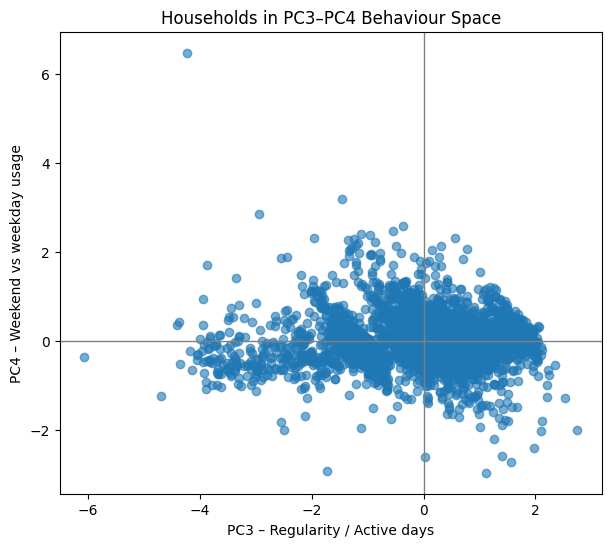

In [102]:
# Scatter PC3 vs PC4 to interpret the new behavioral axes.

import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(
    analysis["PC3"],
    analysis["PC4"],
    alpha=0.6
)

plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)

plt.xlabel("PC3 – Regularity / Active days")
plt.ylabel("PC4 – Weekend vs weekday usage")
plt.title("Households in PC3–PC4 Behaviour Space")
plt.show()


In [103]:
# Bucket households into terciles based on the PC4 weekend bias.

analysis["weekend_type"] = pd.qcut(
    analysis["PC4"],
    q=3,
    labels=["Weekday-heavy", "Balanced", "Weekend-heavy"]
)

analysis["weekend_type"].value_counts()


weekend_type
Weekday-heavy    1843
Weekend-heavy    1843
Balanced         1842
Name: count, dtype: int64

In [107]:
# Purpose: Compare aggregate metrics across the weekend_segment categories.

analysis.groupby("weekend_type")[[
    "mean_daily_kwh",
    "total_kwh",
    "std_daily_kwh",
    "weekend_ratio",
    "weekday_mean"
]].mean()

/var/folders/3g/3ghy995d7p77qhc7cy6bg8x00000gn/T/ipykernel_15335/252167896.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis.groupby("weekend_type")[[


,mean_daily_kwh,total_kwh,std_daily_kwh,weekend_ratio,weekday_mean
weekend_type,,,,,
Weekday-heavy,9.538247,5557.098066,3.661014,0.943497,9.704689
Balanced,10.310634,6633.413648,3.781842,1.042648,10.204955
Weekend-heavy,10.648847,7062.306376,4.201427,1.186980,10.172769


Weekend-heavy households:

High weekday_mean → they already use a lot of energy overall

Even higher weekend usage → pushes the ratio above 1.0

Highest mean_daily_kwh → big households, EVs, heat pumps, home offices, etc.

Highest std_daily_kwh → lots of flexible / movable load

Think of them as “high-energy, flexible households”, not “weekend-only users”.

Why this still makes them “Weekend-heavy”

The label comes from relative behaviour, not absolute levels.

Weekday-heavy

weekend_ratio ≈ 0.94 → weekends use less energy than weekdays

weekday_mean ≈ 9.70 > mean_daily_kwh ≈ 9.54 ✔️

Lower std_daily_kwh → more stable usage

**What this cell does:** Plot PC3 and PC4 positions by the predefined weekend_segment labels.


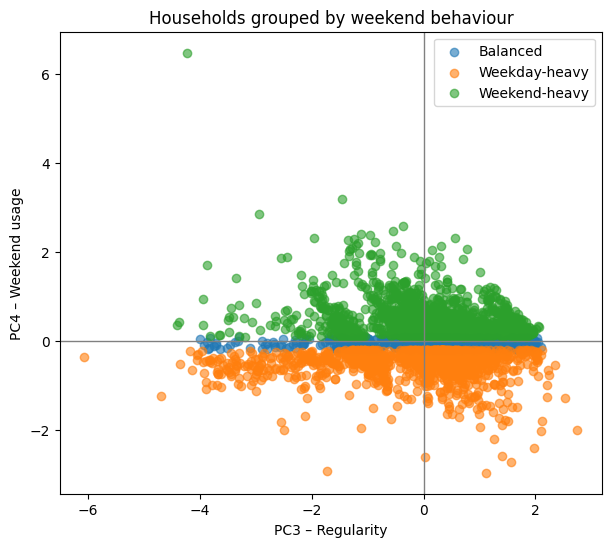

In [108]:
# Plot PC3 and PC4 positions by the predefined weekend_segment labels.

plt.figure(figsize=(7,6))

for label in analysis["weekend_type"].unique():
    subset = analysis[analysis["weekend_type"] == label]
    plt.scatter(
        subset["PC3"],
        subset["PC4"],
        label=label,
        alpha=0.6
    )

plt.axhline(0, color="grey", linewidth=1)
plt.axvline(0, color="grey", linewidth=1)

plt.xlabel("PC3 – Regularity")
plt.ylabel("PC4 – Weekend usage")
plt.title("Households grouped by weekend behaviour")
plt.legend()
plt.show()


In [ ]:
# Run KMeans for cluster counts 2 through 8 and record silhouette scores.
# This helps us decide how many clusters to choose, ideally you want the score to be > 0.5.



import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_beh = analysis[["PC3", "PC4"]].dropna().values

scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_beh)
    scores[k] = silhouette_score(X_beh, labels)

scores

{2: 0.5355850291295696,
 3: 0.41462064260065584,
 4: 0.42539057337152186,
 5: 0.4095154523014635,
 6: 0.37392956665143845,
 7: 0.3576497513837889,
 8: 0.37107675593772826}

In [149]:
# I chose 2 clusters based on silhouette scores, I might reconsider to 3.

K = 2
km = KMeans(n_clusters=K, random_state=42, n_init=10)

analysis = analysis.copy()
analysis["km_cluster"] = km.fit_predict(analysis[["PC3","PC4"]].values)
analysis["km_cluster"].value_counts()

km_cluster
0    4276
1    1252
Name: count, dtype: int64

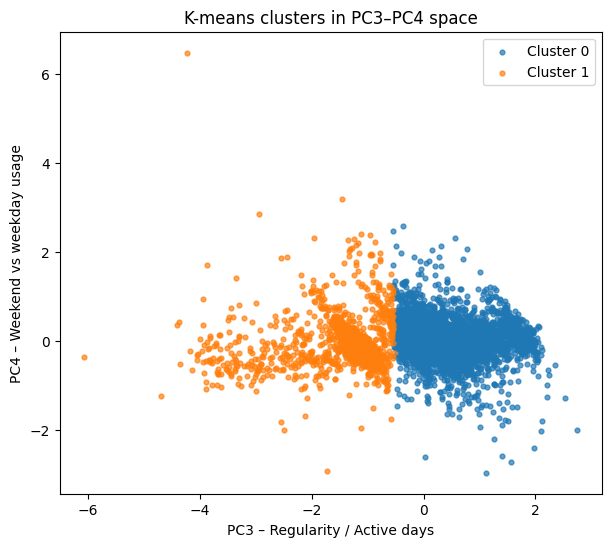

In [150]:
# Plot the KMeans clusters to visually inspect their separation.

import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
for c in sorted(analysis["km_cluster"].unique()):
    sub = analysis[analysis["km_cluster"] == c]
    plt.scatter(sub["PC3"], sub["PC4"], s=12, alpha=0.7, label=f"Cluster {c}")
plt.xlabel("PC3 – Regularity / Active days")
plt.ylabel("PC4 – Weekend vs weekday usage")
plt.title("K-means clusters in PC3–PC4 space")
plt.legend()
plt.show()


In [151]:
# Profile each cluster using the aggregated consumption metrics.

cluster_profile = analysis.groupby("km_cluster")[[
    "active_days","weekend_ratio","winter_summer_ratio",
    "mean_daily_kwh","total_kwh","std_daily_kwh"
]].mean().sort_index()

cluster_profile

,active_days,weekend_ratio,winter_summer_ratio,mean_daily_kwh,total_kwh,std_daily_kwh
km_cluster,,,,,,
0,677.218896,1.044553,2.070291,9.878386,6710.183334,3.728345
1,485.814696,1.102651,1.703807,11.147784,5418.184017,4.404335


In [152]:
# Cross tabulate clusters against tariff types to inspect their mix.

ct = pd.crosstab(analysis["km_cluster"], analysis["stdorToU"], normalize="index")
ct

stdorToU,Std,ToU
km_cluster,,
0,0.796071,0.203929
1,0.805911,0.194089


In [153]:
# Train and evaluate a logistic regression that predicts tariff type from PC3 and PC4.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df_tar = analysis.dropna(subset=["stdorToU","PC3","PC4"]).copy()
y = (df_tar["stdorToU"] == "ToU").astype(int).values
X = df_tar[["PC3","PC4"]].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(Xtr, ytr)

pred = clf.predict(Xte)
print("Accuracy:", accuracy_score(yte, pred))
print(classification_report(yte, pred))

Accuracy: 0.7981186685962374
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1103
           1       0.00      0.00      0.00       279

    accuracy                           0.80      1382
   macro avg       0.40      0.50      0.44      1382
weighted avg       0.64      0.80      0.71      1382



/Users/tanya/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanya/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanya/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [154]:
# Aggregate weekday versus weekend energy totals per household.

# daily must have: LCLid, kwh, is_weekend (0/1)
usage = daily.groupby(["LCLid","is_weekend"])["kwh"].sum().unstack(fill_value=0)
usage.columns = ["weekday_kwh","weekend_kwh"]  # assuming is_weekend 0 then 1
usage.head()

,weekday_kwh,weekend_kwh
LCLid,,
MAC000002,4244.712001,1850.960000
MAC000003,10138.189003,3942.672999
MAC000004,793.331000,326.508000
MAC000005,2076.849000,834.157000
MAC000006,1576.599000,590.849000


In [155]:
# Purpose: Join the aggregated usage back to the analysis table and verify totals.

analysis2 = analysis.join(usage, how="inner")
analysis2["total_kwh_check"] = analysis2["weekday_kwh"] + analysis2["weekend_kwh"]
analysis2.head()

,mean_daily_kwh,median_daily_kwh,max_daily_kwh,std_daily_kwh,total_kwh,active_days,weekday_mean,weekend_mean,weekend_ratio,winter_mean,...,Acorn_grouped,PC1,PC2,PC3,PC4,weekend_type,km_cluster,weekday_kwh,weekend_kwh,total_kwh_check
LCLid,,,,,,,,,,,,,,,,,,,,,
MAC000002,12.070638,11.2140,39.284,4.494518,6095.672001,505,11.758205,12.853889,1.093185,13.203778,...,Affluent,0.640423,-0.058336,-1.288159,-0.032550,Balanced,1,4244.712001,1850.960000,6095.672001
MAC000003,19.028192,13.2045,50.759,11.606123,14080.862003,740,19.128658,18.774633,0.981492,27.588174,...,Adversity,3.655052,1.154395,1.069000,-0.062449,Balanced,0,10138.189003,3942.672999,14080.862003
MAC000004,1.691600,1.6385,7.354,0.431377,1119.839000,662,1.673694,1.736745,1.037672,1.837633,...,Affluent,-3.238355,-0.121311,0.322370,-0.094934,Balanced,0,793.331000,326.508000,1119.839000
MAC000005,4.562705,4.4995,16.708,1.470511,2911.006000,638,4.554493,4.583280,1.006321,5.537317,...,Affluent,-2.100574,0.103294,0.147460,-0.210585,Weekday-heavy,0,2076.849000,834.157000,2911.006000
MAC000006,2.848158,2.8770,6.636,0.882171,2167.448000,761,2.892842,2.735412,0.945579,3.000427,...,Adversity,-2.815370,0.199892,1.387392,-0.284538,Weekday-heavy,0,1576.599000,590.849000,2167.448000


In [156]:
# Create weekend_type labels by binning PC4 into terciles.

analysis2["weekend_type"] = pd.qcut(
    analysis2["PC4"], q=3, labels=["Weekday-heavy","Balanced","Weekend-heavy"]
)
analysis2["weekend_type"].value_counts()

weekend_type
Weekday-heavy    1843
Weekend-heavy    1843
Balanced         1842
Name: count, dtype: int64

In [157]:
# Define a revenue neutral pricing helper and compute rates for weekend heavy homes.

def revenue_neutral_weekday_price(df, discount=0.2, base=1.0):
    Wkday = df["weekday_kwh"].sum()
    Wkend = df["weekend_kwh"].sum()
    baseline = base * (Wkday + Wkend)
    weekend_price = base * (1 - discount)
    weekday_price = (baseline - weekend_price * Wkend) / Wkday
    return weekday_price, weekend_price

seg = analysis2[analysis2["weekend_type"] == "Weekend-heavy"]
weekday_price, weekend_price = revenue_neutral_weekday_price(seg, discount=0.2, base=1.0)
weekday_price, weekend_price


(np.float64(1.0923113380118974), 0.8)

In [158]:
# Estimate baseline versus new bills to quantify the pricing impact.

disc = 0.2
weekday_price, weekend_price = revenue_neutral_weekday_price(seg, discount=disc, base=1.0)

seg = seg.copy()
seg["bill_baseline"] = 1.0 * seg["total_kwh_check"]
seg["bill_new"] = weekday_price * seg["weekday_kwh"] + weekend_price * seg["weekend_kwh"]
seg["bill_delta"] = seg["bill_new"] - seg["bill_baseline"]

seg["bill_delta"].describe()


count    1.843000e+03
mean    -1.603830e-15
std      5.236716e+01
min     -6.981665e+02
25%     -1.815121e+01
50%      1.379503e+00
75%      1.710174e+01
max      5.666572e+02
Name: bill_delta, dtype: float64

bill_delta < 0 → household pays less (a “winner”)

bill_delta > 0 → household pays more (a “loser”)


---

count 1.843000e+03 → you evaluated 1843 households in this segment

mean ~ -1.6e-15 → basically 0, which is what we want for revenue-neutral (tiny floating point rounding)

std 52.37 → spread of changes; people move up/down quite a bit

min -698 → biggest winner saved ~698 “units” (since base=1.0)

max 566 → biggest loser paid ~566 more

median ~1.38 → half pay a tiny bit more, half less (but not exactly symmetrical)

____

Even if total revenue stays the same on average, individual households are redistributed:

Households that are more weekend-skewed than the segment average tend to win

Households that are less weekend-skewed (even within “weekend-heavy”) tend to lose

So this cell is checking:

Can we design a “discount weekend” tariff without losing revenue? ✅

Who gets cheaper vs more expensive bills? ✅

In [160]:
# Measure the share of weekend heavy homes that would save money.

(seg["bill_delta"] < 0).mean()

np.float64(0.47748236570808467)

In [161]:
# Create a binary target flag for weekend heavy households.

analysis2["target_weekend_heavy"] = (analysis2["weekend_type"] == "Weekend-heavy").astype(int)
analysis2["target_weekend_heavy"].value_counts()

target_weekend_heavy
0    3685
1    1843
Name: count, dtype: int64

In [162]:
# Engineer early usage features from the first N days per household.

N_DAYS = 30

d = daily.copy()
d = d.sort_values(["LCLid","date"])

# rank days per household
d["day_rank"] = d.groupby("LCLid")["date"].rank(method="dense").astype(int)

early = d[d["day_rank"] <= N_DAYS].copy()

early_feat = early.groupby("LCLid").agg(
    early_mean_kwh=("kwh","mean"),
    early_std_kwh=("kwh","std"),
    early_total_kwh=("kwh","sum"),
    early_active_days=("kwh","count"),
    early_weekend_mean=("kwh", lambda s: s[early.loc[s.index, "is_weekend"]==1].mean()),
    early_weekday_mean=("kwh", lambda s: s[early.loc[s.index, "is_weekend"]==0].mean()),
)
early_feat["early_weekend_ratio"] = early_feat["early_weekend_mean"] / early_feat["early_weekday_mean"]
early_feat = early_feat.replace([np.inf,-np.inf], np.nan).fillna(0)

early_feat.head()

,early_mean_kwh,early_std_kwh,early_total_kwh,early_active_days,early_weekend_mean,early_weekday_mean,early_weekend_ratio
LCLid,,,,,,,
MAC000002,13.440367,4.389093,403.211,30,16.088000,12.305667,1.307365
MAC000003,20.730833,8.488355,621.925,30,18.563500,21.518955,0.862658
MAC000004,1.488567,0.179706,44.657,30,1.522500,1.476227,1.031345
MAC000005,3.802433,1.182227,114.073,30,3.688111,3.851429,0.957596
MAC000006,3.203733,0.509400,96.112,30,3.251250,3.186455,1.020335


In [163]:
# Join the early usage features with the target to build a modeling set.

clf_df = analysis2[["target_weekend_heavy"]].join(early_feat, how="inner").dropna()
clf_df.shape

(5528, 8)

In [129]:
# Train a logistic regression pipeline that predicts weekend heavy households.

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = clf_df.drop(columns=["target_weekend_heavy"]).values
y = clf_df["target_weekend_heavy"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(Xtr, ytr)
proba = model.predict_proba(Xte)[:,1]
pred = (proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(yte, proba))
print("Accuracy:", accuracy_score(yte, pred))
print(classification_report(yte, pred))

AUC: 0.7972424578584534
Accuracy: 0.7525325615050651
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       921
           1       0.71      0.43      0.54       461

    accuracy                           0.75      1382
   macro avg       0.74      0.67      0.68      1382
weighted avg       0.75      0.75      0.73      1382



In [164]:
# Review the ACORN group distribution across the dataset.

analysis["Acorn_grouped"].value_counts()

Acorn_grouped
Affluent       2183
Adversity      1800
Comfortable    1496
ACORN-U          47
ACORN-            2
Name: count, dtype: int64

In [165]:
# Filter out rows with missing ACORN groups for fairness checks.

fair = analysis[analysis["Acorn_grouped"] != "ACORN-"].copy()

In [166]:
# Compare weekend_segment proportions across ACORN groups.

pd.crosstab(
    fair["Acorn_grouped"],
    fair["weekend_type"],
    normalize="index"
)

weekend_type,Weekday-heavy,Balanced,Weekend-heavy
Acorn_grouped,,,
ACORN-U,0.382979,0.297872,0.319149
Adversity,0.337778,0.332778,0.329444
Affluent,0.347229,0.318369,0.334402
Comfortable,0.305481,0.356952,0.337567


In [ ]:
# Compare cluster distributions across ACORN groups.

pd.crosstab(
    fair["Acorn_grouped"],
    fair["km_cluster"],
    normalize="index"
)


km_cluster,0,1,2
Acorn_grouped,,,
Adversity,0.170000,0.070000,0.760000
Affluent,0.324324,0.081081,0.594595


In [167]:
# Run a chi square test between ACORN group and weekend_segment labels.

from scipy.stats import chi2_contingency

table = pd.crosstab(
    fair["Acorn_grouped"],
    fair["weekend_type"]
)

chi2, p, _, _ = chi2_contingency(table)
chi2, p

(np.float64(9.548764311966996), np.float64(0.1449861763890396))